In [1]:
from GGMS.solvers import *
from GGMS.spd_generators import *
from GGMS.stat_funcs import *
from GGMS.experimenting import *
from GGMS.metrics import *
from tqdm import tqdm
from tqdm.notebook import trange
import pandas as pd
from scipy.stats import hmean
import seaborn as sns

<Axes: ylabel='Count'>

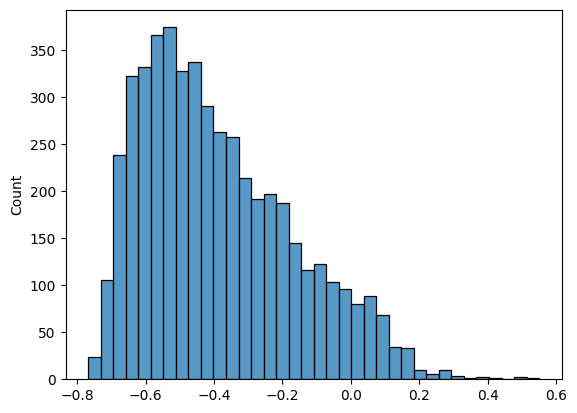

In [5]:
_, _, pc, _, _ = generate_chol_model(100, 0.1)
sns.histplot(pc[np.triu_indices_from(pc, k=1)])

In [3]:
_, _, pc, _, _ = generate_peng_model(100, 0.9)

<Axes: ylabel='Count'>

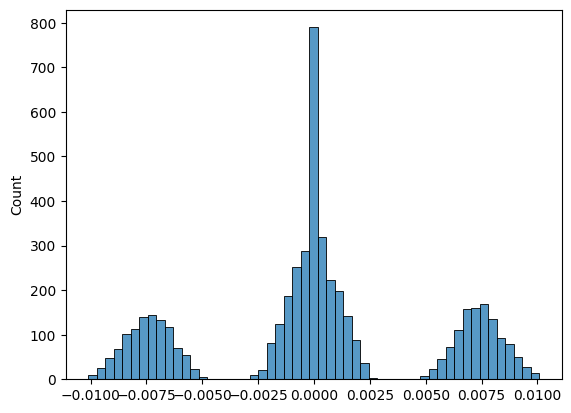

In [4]:
sns.histplot(pc[np.triu_indices_from(pc, k=1)])

In [56]:
N = 20
n = 100
delta = 0.1

In [57]:
precision = np.diag([delta for _ in range(N-1)], 1) + np.diag([delta for _ in range(N-1)], -1) + np.eye(N)
covariance = np.linalg.inv(precision)
pc = pcorr(precision)
ed = pcorr_to_edge_dict(pc)
G = edge_dict_to_graph(ed, N)

In [58]:
#precision, covariance, pc, ed, G = generate_chol_model(20, 0.94)

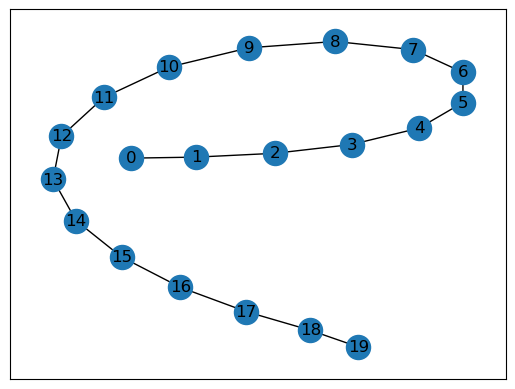

In [59]:
nx.draw_networkx(G)

In [60]:
S_obs = 2000
solvers = [SimInf(), Bonferroni(), Holm(), BenjaminiHochberg(), BenjaminiYekutieli()]

In [62]:
exp1 = perform_experiments_with_given_model(22, covariance, G, S_obs, solvers, [TP, FN, FP, FN, FDR, TPR, F1], ranger=range).T

  0%|          | 0/2000 [00:00<?, ?it/s]

In [63]:
exp2 = perform_experiments_with_given_model(100, covariance, G, S_obs, solvers, [TP, FN, FP, FN, FDR, TPR, F1], ranger=range).T

  0%|          | 0/2000 [00:00<?, ?it/s]

In [64]:
exp3 = perform_experiments_with_given_model(200, covariance, G, S_obs, solvers, [TP, FN, FP, FN, FDR, TPR, F1], ranger=range).T

  0%|          | 0/2000 [00:00<?, ?it/s]

In [68]:
exp1

,TP,FN,FP,FN,FDR,TPR,F1
SimInf,1.9915,17.0085,17.2675,17.0085,0.714941,0.104816,0.064647
Bonferroni,0.0040,18.9960,0.0370,18.9960,0.005194,0.000211,0.000203
Holm,0.0040,18.9960,0.0510,18.9960,0.005223,0.000211,0.000177
BenjaminiHochberg,0.3895,18.6105,3.4825,18.6105,0.031451,0.020500,0.005825
BenjaminiYekutieli,0.0475,18.9525,0.4275,18.9525,0.004053,0.002500,0.000751


In [69]:
exp2

,TP,FN,FP,FN,FDR,TPR,F1
SimInf,4.371,14.629,17.0125,14.629,0.792170,0.230053,0.214799
Bonferroni,0.086,18.914,0.0915,18.914,0.079417,0.004526,0.008531
Holm,0.086,18.914,0.0920,18.914,0.079417,0.004526,0.008531
BenjaminiHochberg,0.117,18.883,0.1450,18.883,0.086590,0.006158,0.011229
BenjaminiYekutieli,0.023,18.977,0.0185,18.977,0.016333,0.001211,0.002281


In [70]:
exp3

,TP,FN,FP,FN,FDR,TPR,F1
SimInf,7.1830,11.8170,17.3445,11.8170,0.703094,0.378053,0.329052
Bonferroni,0.2895,18.7105,0.0900,18.7105,0.071167,0.015237,0.028502
Holm,0.2900,18.7100,0.0905,18.7100,0.071417,0.015263,0.028545
BenjaminiHochberg,0.4025,18.5975,0.1780,18.5975,0.087758,0.021184,0.038004
BenjaminiYekutieli,0.0980,18.9020,0.0180,18.9020,0.015583,0.005158,0.009698
